# Titanic Survival

The task is to predict which passengers will survive the sinking of the titanic given some information about the passengers. Full information is available here: https://www.kaggle.com/competitions/titanic

# Imports

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBClassifier

# Loading Data

In [2]:
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv') # This is a sample submission
train_data = pd.read_csv('../input/titanic/train.csv', index_col='PassengerId')

# EDA

This is a very simple EDA, but this data isn't terribly complicated

In [3]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


What is present in the "Cabin" and "Ticket" column, and if they could be significant isn't immediately obvious, so we investigate further. We'd also like a closer look at the "Name" column.

In [5]:
print(train_data[['Cabin', 'Name', 'Ticket']][:10])

            Cabin                                               Name  \
PassengerId                                                            
1             NaN                            Braund, Mr. Owen Harris   
2             C85  Cumings, Mrs. John Bradley (Florence Briggs Th...   
3             NaN                             Heikkinen, Miss. Laina   
4            C123       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
5             NaN                           Allen, Mr. William Henry   
6             NaN                                   Moran, Mr. James   
7             E46                            McCarthy, Mr. Timothy J   
8             NaN                     Palsson, Master. Gosta Leonard   
9             NaN  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
10            NaN                Nasser, Mrs. Nicholas (Adele Achem)   

                       Ticket  
PassengerId                    
1                   A/5 21171  
2                    PC 17599  
3      

What percentage of the "Cabin" column is Nan and how many unique values are present?

In [6]:
print(sum(train_data['Cabin'].isna())/train_data.shape[0])
print(train_data['Cabin'].nunique())

0.7710437710437711
147


Check for missing values in other columns

In [7]:
for column in train_data.columns:
    number_missing = sum(train_data[column].isna())
    if number_missing:
        percentage_missing = number_missing/train_data.shape[0]
        print(f'{percentage_missing}% of the column "{column}" was missing ({number_missing} values)')

0.19865319865319866% of the column "Age" was missing (177 values)
0.7710437710437711% of the column "Cabin" was missing (687 values)
0.002244668911335578% of the column "Embarked" was missing (2 values)


We now generate some plots to see who is surviving.

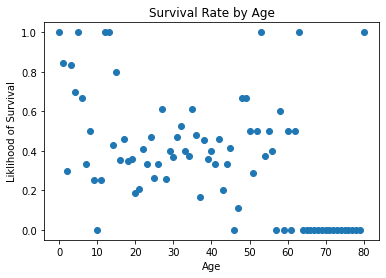

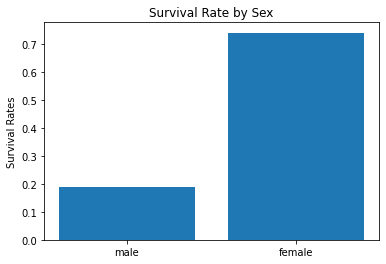

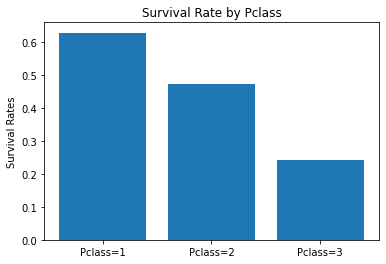

In [8]:
labels = train_data['Survived']
ages = [*range(round(max(train_data['Age'])+1))]
survivals = np.zeros((len(ages), 2))
for ind in range(1, train_data.shape[0]):
    try:
        age = round(train_data['Age'][ind])
    except:
        continue # Skip missing values for now
    survived = labels[ind]
    survivals[age, 0] += 1
    survivals[age, 1] += survived
for ind in range(survivals.shape[0]):
    if survivals[ind, 0] == 0:
        survivals[ind, 0] = 1 # Cleaning up division by 0
survival_rates = survivals[:, 1]/survivals[:, 0]
plt.figure()
plt.scatter(ages, survival_rates)
plt.title('Survival Rate by Age')
plt.xlabel('Age')
plt.ylabel('Liklihood of Survival')
plt.show()
num_females = sum(train_data['Sex']=='female')
num_males = sum(train_data['Sex']=='male')
female_survivors = sum((train_data['Sex']=='female')*labels)
male_survivors = sum((train_data['Sex']=='male')*labels)
plt.figure()
plt.bar(['male', 'female'], [male_survivors/num_males, female_survivors/num_females])
plt.title('Survival Rate by Sex')
plt.ylabel('Survival Rates')
plt.show()
num_pclass1 = sum(train_data['Pclass']==1)
num_pclass2 = sum(train_data['Pclass']==2)
num_pclass3 = sum(train_data['Pclass']==3)
pclass1_survivors = sum((train_data['Pclass']==1)*labels)
pclass2_survivors = sum((train_data['Pclass']==2)*labels)
pclass3_survivors = sum((train_data['Pclass']==3)*labels)
plt.figure()
plt.bar(['Pclass=1', 'Pclass=2', 'Pclass=3'], [pclass1_survivors/num_pclass1, pclass2_survivors/num_pclass2, pclass3_survivors/num_pclass3])
plt.title('Survival Rate by Pclass')
plt.ylabel('Survival Rates')
plt.show()

We also check the total number of survivors to see if the classes in this dataset are unbalanced.

In [9]:
print(f'Percentage Survived: {sum(labels)/len(labels)}')
print(f'Percentage Deceased: {sum(labels==0)/len(labels)}')

Percentage Survived: 0.3838383838383838
Percentage Deceased: 0.6161616161616161


This dataset is imbalanced, but not to the point where it should be a significant problem for us. Poking around the data we also notice that some passengers have titles, so we try to extract those and see what is present in the dataset. A title may be a signal of a high social class and therefore indicate survival. This effect should theoretically be taken care of by the "Pclass" but we try it anyway as the methodology used to generate that score is unclear. We keep only titles that occur more than once so as to avoid flukes.

In [10]:
titles = []
for ind in range(1, train_data.shape[0]):
    match = re.search(r'\s(\S+?)\.', train_data['Name'][ind])
    if match:
        if match[1] not in titles:
            titles.append(match[1])
print(titles)

['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess', 'Jonkheer']


We decide to map titles by category since some of these are pretty niche and unlikely to occur more than once.

In [11]:
titles_mapping = {
    'Mr':'Mr',
    'Mrs':'Mrs',
    'Miss':'Miss',
    'Master':'Officer',
    'Don':'Nobility',
    'Rev':'Officer',
    'Dr':'Officer',
    'Mme':'Mrs',
    'Ms':'Mrs',
    'Major':'Officer',
    'Lady':'Nobility',
    'Sir':'Nobility',
    'Mlle':'Miss',
    'Col':'Officer',
    'Capt':'Officer',
    'Countess':'Nobility',
    'Jonkheer':'Nobility'
}

We now check if any titles are present in the test set that aren't present in the training set.

In [12]:
test_data = pd.read_csv('../input/titanic/test.csv', index_col='PassengerId')
test_titles = []
for ind in range(1, test_data.shape[0]):
    match = re.search(r'\s(\S+?)\.', test_data['Name'][891+ind])
    if match:
        if match[1] not in titles:
            test_titles.append(match[1])
print(test_titles)

['Dona']


We now add this title to our mapping

In [13]:
titles.extend(test_titles)
titles_mapping['Dona'] = 'Nobility'
print(titles)

['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess', 'Jonkheer', 'Dona']


In [14]:
for title in titles:
    count = sum(train_data['Name'].str.contains(fr'\s{title}\.').astype(int))
    print(f'title: {title} count: {count}')

title: Mr count: 517
title: Mrs count: 125
title: Miss count: 182
title: Master count: 40
title: Don count: 1
title: Rev count: 6
title: Dr count: 7
title: Mme count: 1
title: Ms count: 1
title: Major count: 2
title: Lady count: 1
title: Sir count: 1
title: Mlle count: 2
title: Col count: 2
title: Capt count: 1
title: Countess count: 1
title: Jonkheer count: 1
title: Dona count: 0


# Creating a Pipeline

The most useful part of the Cabin number is likely to be the first letter, which denotes which deck the passengers cabin was on. However, the number may also be useful as it is correlated with the location of the cabin within the deck and the location of the passengers cabin may determine their ability to escape during the sinking. Therefore, we break the "Cabin" column into two columns, a categorical column for the deck of the passenger's cabin and a numerical column for the number of the passenger's cabin. The ticket number doesn't seem to have any useful information so we drop it.

In [15]:
# Checking which cabin levels are present in our dataset
cabin_levels = train_data['Cabin'].str.slice(stop=1)
cabin_levels.unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [16]:
def process_data(dataset, mean_cabin_number=None, test=False):
    ds = dataset.copy()
    for title in titles: # One hot encoding titles
        if titles_mapping[title] in ds.columns:
            ds[titles_mapping[title]] += ds['Name'].str.contains(fr'\s{title}\.').astype(int)
        else:
            ds[titles_mapping[title]] = ds['Name'].str.contains(fr'\s{title}\.').astype(int)
    for level in cabin_levels.unique()[1:]:
        ds[f'{level}_Level'] = ds['Cabin'].str.startswith(f'{level}') & ~ds['Cabin'].isna()
        ds[f'{level}_Level'] = ds[f'{level}_Level'].astype('int')
    ds['CabinNumber'] = ds['Cabin'].str.extract(r'(\d+)').astype('float')
    ds['Sex'] = (ds['Sex']=='male').astype('int')
    ds = pd.get_dummies(ds, columns=['Embarked', 'Pclass'], prefix=['Embarked', 'Pclass'])
    if test:
        ds['CabinNumber'].fillna(mean_cabin_number, inplace=True) # Using mean imputation for the cabin number
        ds['Age'].fillna(train_data['Age'].mean(), inplace=True) # Using mean imputation for the age
        ds.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)
        return ds
    else:
        mean_cabin_number = ds['CabinNumber'].mean()
        ds['CabinNumber'].fillna(mean_cabin_number, inplace=True) # Using mean imputation for the cabin number
        ds['Age'].fillna(ds['Age'].mean(), inplace=True) # Using mean imputation for the age
        ds.drop(['Cabin', 'Name', 'Survived', 'Ticket'], axis=1, inplace=True)
        # Separating out the labels
        labels = dataset['Survived'].copy()
        return ds, labels, mean_cabin_number

Confirming that our changes work as expected

In [17]:
train_ds, labels, mean_cabin_number = process_data(train_data)
train_ds.head()

,Sex,Age,SibSp,Parch,Fare,Mr,Mrs,Miss,Officer,Nobility,...,B_Level,F_Level,T_Level,CabinNumber,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,1,22.0,1,0,7.2500,1,0,0,0,0,...,0,0,0,50.49,0,0,1,0,0,1
2,0,38.0,1,0,71.2833,0,1,0,0,0,...,0,0,0,85.00,1,0,0,1,0,0
3,0,26.0,0,0,7.9250,0,0,1,0,0,...,0,0,0,50.49,0,0,1,0,0,1
4,0,35.0,1,0,53.1000,0,1,0,0,0,...,0,0,0,123.00,0,0,1,1,0,0
5,1,35.0,0,0,8.0500,1,0,0,0,0,...,0,0,0,50.49,0,0,1,0,0,1


In [18]:
train_ds.describe()

,Sex,Age,SibSp,Parch,Fare,Mr,Mrs,Miss,Officer,Nobility,...,B_Level,F_Level,T_Level,CabinNumber,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.647587,29.699118,0.523008,0.381594,32.204208,0.580247,0.142536,0.206510,0.065095,0.005612,...,0.052750,0.014590,0.001122,50.490000,0.188552,0.086420,0.722783,0.242424,0.206510,0.551066
std,0.477990,13.002015,1.102743,0.806057,49.693429,0.493796,0.349796,0.405028,0.246833,0.074743,...,0.223659,0.119973,0.033501,16.736825,0.391372,0.281141,0.447876,0.428790,0.405028,0.497665
min,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,50.490000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,29.699118,0.000000,0.000000,14.454200,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,50.490000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,50.490000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,148.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We now use a random forest classifier to find the most important features and reduce the size of the dataset

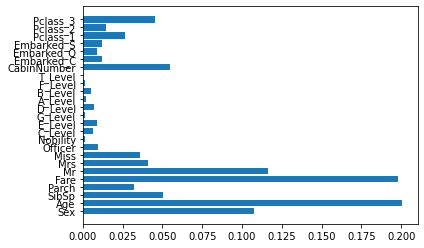

In [19]:
rf = RandomForestClassifier()
rf.fit(train_ds, labels)
plt.figure()
plt.barh(train_ds.columns, rf.feature_importances_)
plt.show()

From this we decide the use the 10 most predictive features, which are more significant than the rest

In [20]:
important_columns = train_ds.columns[np.argsort(rf.feature_importances_)][-10:]
def refine_ds(ds):
    return ds[important_columns].copy()

In [21]:
train_ds = refine_ds(train_ds)
train_ds.head()

,Parch,Miss,Mrs,Pclass_3,SibSp,CabinNumber,Sex,Mr,Fare,Age
PassengerId,,,,,,,,,,
1,0,0,0,1,1,50.49,1,1,7.2500,22.0
2,0,0,1,0,1,85.00,0,0,71.2833,38.0
3,0,1,0,1,0,50.49,0,0,7.9250,26.0
4,0,0,1,0,1,123.00,0,0,53.1000,35.0
5,0,0,0,1,0,50.49,1,1,8.0500,35.0


In [22]:
train_ds.describe()

,Parch,Miss,Mrs,Pclass_3,SibSp,CabinNumber,Sex,Mr,Fare,Age
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.381594,0.206510,0.142536,0.551066,0.523008,50.490000,0.647587,0.580247,32.204208,29.699118
std,0.806057,0.405028,0.349796,0.497665,1.102743,16.736825,0.477990,0.493796,49.693429,13.002015
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.420000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,50.490000,0.000000,0.000000,7.910400,22.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,50.490000,1.000000,1.000000,14.454200,29.699118
75%,0.000000,0.000000,0.000000,1.000000,1.000000,50.490000,1.000000,1.000000,31.000000,35.000000
max,6.000000,1.000000,1.000000,1.000000,8.000000,148.000000,1.000000,1.000000,512.329200,80.000000


# Creating Models

In [23]:
def get_avg_model_accuracy(model, ds):
    return np.mean(cross_val_score(model, ds, labels, n_jobs=-1, scoring='accuracy'))

In [24]:
baseline = XGBClassifier(random_state=42)
accuracy = get_avg_model_accuracy(baseline, train_ds)
print(f'The baseline accuracy is {accuracy}')

The baseline accuracy is 0.8170547988199109


In [25]:
model = XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42)
accuracy = get_avg_model_accuracy(model, train_ds)
print(f'The accuracy of this model was {accuracy}')

The accuracy of this model was 0.8170547988199109


From this we can see that the default value of n_estimators is clearly 100 since the score matches exactly. We then perform hyperparameter optimization

In [26]:
run_grid_search = False
if run_grid_search:

    param_grid = {
        'learning_rate':[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
        'max_depth': [None, *range(1, 11)],
        'n_estimators':[1, 5, 10, 50, 100, 200],
    }
    grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, n_jobs=-1)
    grid_search.fit(train_ds, labels)
    print('The best parameters are:')
    print(grid_search.best_params_)

We then take these parameters and form our final model. Also generating the model's score on our test dataset

In [27]:
model = XGBClassifier(learning_rate=0.4, max_depth=3, n_estimators=50, n_jobs=-1)
model.fit(train_ds, labels)
accuracy = get_avg_model_accuracy(model, train_ds)
print(f'The accuracy of this model on the training set was {accuracy}')

The accuracy of this model on the training set was 0.8339150084740442


# Generating Predictions

With our final model we can generate predictions for the test data. However we must first load and process the test data

In [28]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [29]:
test_ds = process_data(test_data, mean_cabin_number=mean_cabin_number, test=True)
test_ds = refine_ds(test_ds)
test_ds.head()

,Parch,Miss,Mrs,Pclass_3,SibSp,CabinNumber,Sex,Mr,Fare,Age
PassengerId,,,,,,,,,,
892,0,0,0,1,0,50.49,1,1,7.8292,34.5
893,0,0,1,1,1,50.49,0,0,7.0000,47.0
894,0,0,0,0,0,50.49,1,1,9.6875,62.0
895,0,0,0,1,0,50.49,1,1,8.6625,27.0
896,1,0,1,1,1,50.49,0,0,12.2875,22.0


In [30]:
predictions = pd.DataFrame(model.predict(test_ds))
predictions.columns = ['Survived']
predictions.index = test_data.index
predictions.head() # making sure we match the form of the example submission

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [31]:
predictions.to_csv('submission.csv')